# GarP
In this project I aim to solve a problem that I faced in TÜBİTAK, in refectory when we are putting our tray's we have to throw recycleable things like glass or plastics into correct recycle bins. When someone throw it incorrect bin, it goes like that, it is not effective and bad for our world.
That's why I will do this project by using what I learned in this internship.

First download datasets from thoose links than copy paste the images under correct classes after than you can zip it by looking the namings in the code:
- [Dataset1](https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification)
- [Dataset2](https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2)

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary


# Google Colab Settings

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%pwd
%ls
%cd drive/MyDrive/GarbageCollector
%ls

drive/  sample_data/
/content/drive/MyDrive/GarbageCollector
best_garbage_classifier.pth                garbage_classifier.ipynb  optic_classifier.ipynb
cnn_transfer_learning_tensorflow_keras.py  Garbage_types.zip         Test/


## Activate GPU

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Transform the Data
Apply different techniques to augmentate the data

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),  # Randomly rotate the image by up to 10 degrees
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop and resize the image
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Apply random changes to brightness, contrast, saturation, and hue
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image with mean 0.5 and standard deviation 0.5
])

### Reading from Zip

In [6]:
import zipfile

temp_dir = 'temp_Garbage_types'

# Open zip file
with zipfile.ZipFile('Garbage_types.zip', 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

# Read the Dataset
dataset = datasets.ImageFolder(root=temp_dir, transform=transform)

In [7]:
# %pwd
%ls

best_garbage_classifier.pth                garbage_classifier.ipynb  optic_classifier.ipynb  Test/
cnn_transfer_learning_tensorflow_keras.py  Garbage_types.zip         temp_Garbage_types/


### Read the dataset from folder

In [8]:
dataset = datasets.ImageFolder('temp_Garbage_types/Garbage_types', transform=transform)

print(f'Total number of images in dataset: {len(dataset)}')

Total number of images in dataset: 16937


In [9]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f'Training set size: {len(train_dataset)}')
print(f'Validation set size: {len(val_dataset)}')
print(f'Test set size: {len(test_dataset)}')


Training set size: 13549
Validation set size: 1693
Test set size: 1695


In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

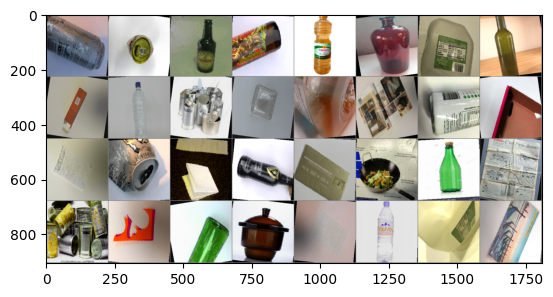

Metal Metal Glass Glass Plastic Glass Plastic Glass
Paper Plastic Metal Plastic Plastic Paper Plastic Cardboard
Paper Metal Paper Glass Paper Cardboard Glass Paper
Metal Paper Glass Glass Paper Plastic Plastic Paper


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Get the class names
class_names = dataset.classes

def imshow(img):
    img = img / 2 + 0.5  # Reverse normalization 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Take one batch from training set
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

# Show images
imshow(torchvision.utils.make_grid(images))

# Write the class names
print('\n'.join(' '.join(f'{class_names[labels[j]]}' for j in range(i, min(i + 8, len(labels)))) for i in range(0, len(labels), 8)))



## This is the model that we used as pretrained

In [12]:
# Upload the pretrained VGG16 model
VGG16_pretrained = models.vgg16(pretrained=True).to(device) # .to(device) is essential to run on GPU

# help(summary)

summary(VGG16_pretrained, (3, 224, 224))
print(VGG16_pretrained)

# VGG16_pretrained.features


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 87.0MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## Create Neural Network Structure

In [13]:
# Change the model name
VGG16_trash_classifier = VGG16_pretrained

# Freeze the pretrained convolutional layers in 'features'
for param in VGG16_trash_classifier.features.parameters():
    param.requires_grad = False

# Get the classifier structure and protect first tree layer
classifier_first_part = VGG16_trash_classifier.classifier[:3]

# Let's create our layers
additional_layers = nn.Sequential(
    nn.Linear(4096, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(256, 6)  # For last layer 6 output
)

# Create new classifier structure
trash_classifier = nn.Sequential(
    *classifier_first_part,
    *additional_layers
)

# Replace the classifier in VGG16 model with your 'trash_classifier'
VGG16_trash_classifier.classifier = trash_classifier

# Freeze all parameters of classifier
for param in VGG16_trash_classifier.classifier.parameters():
    param.requires_grad = False

# Only make our layers trainable
for param in VGG16_trash_classifier.classifier[3:].parameters():
    param.requires_grad = True

VGG16_trash_classifier.to(device)

# Verify the model structure
summary(VGG16_trash_classifier, (3, 224, 224))
print(VGG16_trash_classifier)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

### Early Stopping

In [14]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

early_stopper = EarlyStopper(patience=20, min_delta=0.1)

## Train the VGG16_trash_classifier

In [15]:
from tqdm import tqdm  # To visualize the learning process

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(VGG16_trash_classifier.classifier.parameters(), lr=0.001)

num_epochs = 5
best_val_loss = np.inf
best_model_wts = VGG16_trash_classifier.state_dict()

for epoch in range(num_epochs):
    VGG16_trash_classifier.train()
    running_loss = 0.0
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device) # For GPU
            optimizer.zero_grad()
            outputs = VGG16_trash_classifier(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'Train Loss': running_loss / len(train_loader)})
            pbar.update(1)

    avg_train_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss}')

    # Calculate validation loss
    VGG16_trash_classifier.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device) # For GPU
            val_outputs = VGG16_trash_classifier(val_inputs)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(validation_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss}')

    # Check early stopping
    if early_stopper.early_stop(avg_val_loss):
        print(f'Early stopping at epoch {epoch + 1}')
        n_epoch = epoch + 1
        break

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = VGG16_trash_classifier.state_dict()

print('Finished Training')



Epoch 1/5: 100%|██████████| 424/424 [05:19<00:00,  1.33batch/s, Train Loss=0.805]


Epoch [1/5], Train Loss: 0.8053239210034316
Epoch [1/5], Validation Loss: 0.5299916762226032


Epoch 2/5: 100%|██████████| 424/424 [04:44<00:00,  1.49batch/s, Train Loss=0.608]


Epoch [2/5], Train Loss: 0.6083797009415784
Epoch [2/5], Validation Loss: 0.4507082278998393


Epoch 3/5: 100%|██████████| 424/424 [04:42<00:00,  1.50batch/s, Train Loss=0.551]


Epoch [3/5], Train Loss: 0.550743446562369
Epoch [3/5], Validation Loss: 0.3825307030160472


Epoch 4/5: 100%|██████████| 424/424 [04:51<00:00,  1.45batch/s, Train Loss=0.503]


Epoch [4/5], Train Loss: 0.5033681576474095
Epoch [4/5], Validation Loss: 0.37079458641556073


Epoch 5/5: 100%|██████████| 424/424 [04:43<00:00,  1.49batch/s, Train Loss=0.478]


Epoch [5/5], Train Loss: 0.47805838833369735
Epoch [5/5], Validation Loss: 0.3344470147254332
Finished Training


## Download the trained model

In [16]:
# Gets the best weights during training
# VGG16_trash_classifier.load_state_dict(best_model_wts)

# Save the model
torch.save(VGG16_trash_classifier, 'best_garbage_classifier.pt')

## Upload the model weights
# VGG16_trash_classifier.load_state_dict(torch.load('best_garbage_classifier.pth'))


In [27]:
# Save class names into a txt file
with open('class_names.txt', 'w') as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")

## Test the VGG16_trash_classifier with Unseen Examples from Dataset

In [17]:
# Test the model
VGG16_trash_classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # For GPU
        outputs = VGG16_trash_classifier(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total}%')

Accuracy of the network on the test images: 89.49852507374631%


## Test the Model with Unseen External Images
( I created another comprehensive file for this part, this is just for testing )

In [26]:
from PIL import Image

image_path = 'Test/Kagıt.jpg'
image = Image.open(image_path)

image = transform(image).unsqueeze(0).to(device) # To batch size add unsqueze

# Take the model into evaluation mode
VGG16_trash_classifier.eval()

# Give images to model and predict
with torch.no_grad():
    output = VGG16_trash_classifier(image)
    _, predicted = torch.max(output.data, 1)
    predicted_class = class_names[predicted.item()]

print(f'The model predicts this image as: {predicted_class}')

The model predicts this image as: Paper


## Remove Unnecessary Files

In [19]:
import shutil

# After getting the images, clear all directory
shutil.rmtree(temp_dir)